### F1 lap time prediction

Today, I have 24 hours to gather, analyse and train all race data (including lap times, circuit infos, pit_stops, etc) since the start of the 2011 season.
The main objective is to make a prediction of the following lap time for a given car. 

If we succeed, we can try to expend the prediction with two new features :
- Predict the lap time at lap l+n, l being the last lap completed (to predict the degradation, etc)
- Predict the lap time at lap l+n, with a pit stop at lap l+m with m<n

I already tried to resolve this issue using regression models, the result was really bad, let's try with some timeseries

Let start by gathering data from the "Formula 1 World Championship (1950 - 2023)" Kaggle : https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import numpy as np
import statsmodels.api as sm


In [40]:
lap_times = pd.read_csv("../data/lap_times.csv")
pit_stops = pd.read_csv("../data/pit_stops.csv")
races = pd.read_csv("../data/races.csv")
drivers = pd.read_csv("../data/drivers.csv")

#### Lap times

Here is out main dataset !
We can find every lap of every driver of every gp from the start of 1996 season to the end of 2022 season

Later, we should try to add 2023 first three GPs in the dataset

In [41]:
lap_times.sort_values("raceId")

,raceId,driverId,lap,position,time,milliseconds
343807,1,18,38,1,1:28.438,88438
343543,1,20,21,2,1:46.868,106868
343544,1,20,22,2,2:38.375,158375
343545,1,20,23,2,2:31.909,151909
343546,1,20,24,2,2:22.185,142185
...,...,...,...,...,...,...
537373,1096,847,25,5,1:30.665,90665
537372,1096,847,24,5,1:30.765,90765
537371,1096,847,23,5,1:30.663,90663
537377,1096,847,29,5,1:30.471,90471


#### Races

This is the list of every gp from the start of 2009 to the end of 2023, it will be usefull to have some info about the circuit

In [42]:
races.sort_values(["year", "round"])

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
832,833,1950,1,9,British Grand Prix,1950-05-13,\N,http://en.wikipedia.org/wiki/1950_British_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
833,834,1950,2,6,Monaco Grand Prix,1950-05-21,\N,http://en.wikipedia.org/wiki/1950_Monaco_Grand...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
834,835,1950,3,19,Indianapolis 500,1950-05-30,\N,http://en.wikipedia.org/wiki/1950_Indianapolis...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
835,836,1950,4,66,Swiss Grand Prix,1950-06-04,\N,http://en.wikipedia.org/wiki/1950_Swiss_Grand_...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
836,837,1950,5,13,Belgian Grand Prix,1950-06-18,\N,http://en.wikipedia.org/wiki/1950_Belgian_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,1116,2023,19,69,United States Grand Prix,2023-10-22,19:00:00,https://en.wikipedia.org/wiki/2023_United_Stat...,2023-10-20,17:30:00,2023-10-21,18:00:00,\N,\N,2023-10-20,21:00:00,2023-10-21,22:00:00
1098,1117,2023,20,32,Mexico City Grand Prix,2023-10-29,20:00:00,https://en.wikipedia.org/wiki/2023_Mexico_City...,2023-10-27,18:30:00,2023-10-27,22:00:00,2023-10-28,17:30:00,2023-10-28,21:00:00,\N,\N
1099,1118,2023,21,18,São Paulo Grand Prix,2023-11-05,17:00:00,https://en.wikipedia.org/wiki/2023_S%C3%A3o_Pa...,2023-11-03,14:30:00,2023-11-04,14:30:00,\N,\N,2023-11-03,18:00:00,2023-11-04,18:30:00
1100,1119,2023,22,80,Las Vegas Grand Prix,2023-11-19,06:00:00,https://en.wikipedia.org/wiki/2023_Las_Vegas_G...,2023-11-17,04:30:00,2023-11-17,08:00:00,2023-11-18,04:30:00,2023-11-18,08:00:00,\N,\N


#### Pit_stops

Same as the lap_times, we have here all the pit stops

In [43]:
pit_stops = pit_stops.sort_values("raceId").reset_index(drop=True)
pit_stops

,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,17,2,26,17:44:29,22.520,22520
2,841,4,2,27,17:46:04,24.733,24733
3,841,22,3,28,17:49:07,16.892,16892
4,841,67,2,29,17:49:47,23.100,23100
...,...,...,...,...,...,...,...
9629,1096,840,1,13,17:23:19,21.814,21814
9630,1096,848,1,12,17:21:53,21.793,21793
9631,1096,846,2,42,18:07:36,21.559,21559
9632,1096,817,1,19,17:32:38,21.893,21893


#### Drivers

Just a simple drivers list, with their ids

In [44]:
drivers = drivers.sort_values("driverId").reset_index(drop=True)
drivers

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen
...,...,...,...,...,...,...,...,...,...
852,854,mick_schumacher,47,MSC,Mick,Schumacher,1999-03-22,German,http://en.wikipedia.org/wiki/Mick_Schumacher
853,855,zhou,24,ZHO,Guanyu,Zhou,1999-05-30,Chinese,http://en.wikipedia.org/wiki/Guanyu_Zhou
854,856,de_vries,45,DEV,Nyck,de Vries,1995-02-06,Dutch,http://en.wikipedia.org/wiki/Nyck_de_Vries
855,857,piastri,81,PIA,Oscar,Piastri,2001-04-06,Australian,http://en.wikipedia.org/wiki/Oscar_Piastri


Let's join everything we have !

In [45]:
df_merged = pd.merge(lap_times, drivers, on='driverId')
df_merged = pd.merge(df_merged, races, on='raceId')
#The race ids are not ordered by date
df_merged = df_merged.sort_values(["year", "round", "lap", "position"]).reset_index(drop=True)
df_merged = df_merged[["raceId","year","name", "round", "lap", "driverRef", "driverId", "position", "time_x", "milliseconds", "date","time_y", "circuitId"]]
df_merged = df_merged[df_merged["time_y"]!=r"\N"]
df_merged["time_x"] = df_merged["time_x"].apply(lambda x: '0:' + x if len(x.split(':')) == 2 else x)
df_merged["time_x"] = pd.to_timedelta(df_merged['time_x'])
df_merged

,raceId,year,name,round,lap,driverRef,driverId,position,time_x,milliseconds,date,time_y,circuitId
150951,71,2005,Australian Grand Prix,1,1,fisichella,21,1,0 days 00:01:37.236000,97236,2005-03-06,14:00:00,1
150952,71,2005,Australian Grand Prix,1,1,trulli,15,2,0 days 00:01:38.665000,98665,2005-03-06,14:00:00,1
150953,71,2005,Australian Grand Prix,1,1,coulthard,14,3,0 days 00:01:39.425000,99425,2005-03-06,14:00:00,1
150954,71,2005,Australian Grand Prix,1,1,webber,17,4,0 days 00:01:40.045000,100045,2005-03-06,14:00:00,1
150955,71,2005,Australian Grand Prix,1,1,heidfeld,2,5,0 days 00:01:40.959000,100959,2005-03-06,14:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
538116,1096,2022,Abu Dhabi Grand Prix,22,58,ocon,839,7,0 days 00:01:30.021000,90021,2022-11-20,13:00:00,24
538117,1096,2022,Abu Dhabi Grand Prix,22,58,stroll,840,8,0 days 00:01:31.330000,91330,2022-11-20,13:00:00,24
538118,1096,2022,Abu Dhabi Grand Prix,22,58,ricciardo,817,9,0 days 00:01:30.856000,90856,2022-11-20,13:00:00,24
538119,1096,2022,Abu Dhabi Grand Prix,22,58,vettel,20,10,0 days 00:01:30.351000,90351,2022-11-20,13:00:00,24


Let's plot it !

In [46]:
#First, we will watch the lap times of a specific driver, on a specific gp

df_OCO_ABU2022 = df_merged.loc[(df_merged["year"]==2022) & (df_merged["name"]=="Abu Dhabi Grand Prix") & (df_merged["driverRef"]=="ocon")]
df_OCO_ABU2022.head()

,raceId,year,name,round,lap,driverRef,driverId,position,time_x,milliseconds,date,time_y,circuitId
537011,1096,2022,Abu Dhabi Grand Prix,22,1,ocon,839,8,0 days 00:01:36.964000,96964,2022-11-20,13:00:00,24
537031,1096,2022,Abu Dhabi Grand Prix,22,2,ocon,839,8,0 days 00:01:32.136000,92136,2022-11-20,13:00:00,24
537051,1096,2022,Abu Dhabi Grand Prix,22,3,ocon,839,8,0 days 00:01:31.385000,91385,2022-11-20,13:00:00,24
537071,1096,2022,Abu Dhabi Grand Prix,22,4,ocon,839,8,0 days 00:01:31.427000,91427,2022-11-20,13:00:00,24
537091,1096,2022,Abu Dhabi Grand Prix,22,5,ocon,839,8,0 days 00:01:31.722000,91722,2022-11-20,13:00:00,24


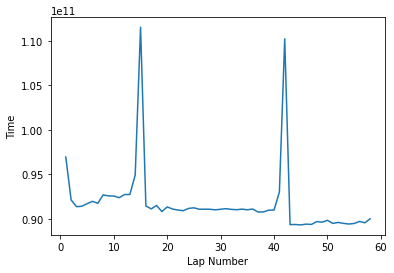

In [47]:
plt.plot(df_OCO_ABU2022["lap"], df_OCO_ABU2022["time_x"], label='Time by lap')
plt.ylabel('Time')
plt.xlabel('Lap Number')
plt.show()

It's easy to see the two pit stops Ocon had. Let's drop those rows to have beter details

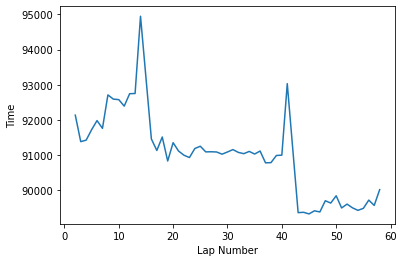

In [48]:
df_OCO_ABU2022_NOSTOP = df_OCO_ABU2022[df_OCO_ABU2022['time_x'] <= pd.Timedelta(minutes=1, seconds=35)]
plt.plot(df_OCO_ABU2022_NOSTOP["lap"], df_OCO_ABU2022_NOSTOP["milliseconds"], label='Time by lap')
plt.ylabel('Time')
plt.xlabel('Lap Number')
plt.show()

Let's try a really simple, one variable timeSerie resolution, we will use the lap as the "time" index

In [49]:
ts_OCO_ABU2022 = df_OCO_ABU2022[["date", "time_y","lap", "milliseconds"]]
#I volontarely add only one minute by lap
ts_OCO_ABU2022["ds"] = ts_OCO_ABU2022.apply(lambda row : np.datetime64(row.date+'T'+row.time_y)+np.timedelta64(row.lap,'m'), axis=1)
ts_OCO_ABU2022 = ts_OCO_ABU2022.rename(columns={"milliseconds":"y"}).reset_index(drop=True)[["ds",'y']]
ts_OCO_ABU2022

<ipython-input-49-b5c4dca0c41a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_OCO_ABU2022["ds"] = ts_OCO_ABU2022.apply(lambda row : np.datetime64(row.date+'T'+row.time_y)+np.timedelta64(row.lap,'m'), axis=1)


,ds,y
0,2022-11-20 13:01:00,96964
1,2022-11-20 13:02:00,92136
2,2022-11-20 13:03:00,91385
3,2022-11-20 13:04:00,91427
4,2022-11-20 13:05:00,91722
5,2022-11-20 13:06:00,91982
6,2022-11-20 13:07:00,91762
7,2022-11-20 13:08:00,92711
8,2022-11-20 13:09:00,92592
9,2022-11-20 13:10:00,92577


In [50]:
ts_train = ts_OCO_ABU2022[:4]
ts_test = ts_OCO_ABU2022[-4:]
ts_test_ds = ts_test[["ds"]]

print(ts_train.shape)
print(ts_test.shape)
print(ts_test_ds.shape)
ts_test

(4, 2)
(4, 2)
(4, 1)


,ds,y
54,2022-11-20 13:55:00,89491
55,2022-11-20 13:56:00,89725
56,2022-11-20 13:57:00,89574
57,2022-11-20 13:58:00,90021


In [51]:
m = Prophet()
m.fit(ts_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.


In [ ]:
forecast = m.predict(ts_test_ds)
forecast["y"] = ts_test["y"].reset_index(drop=True)
forecast["diff (s)"] = (forecast["yhat"]-forecast["y"])/1000

print("mean of the diff : ",np.mean(abs(forecast["diff (s)"])))

forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', "diff (s)"]]


mean of the diff :  3.9292499999999997


,ds,y,yhat,yhat_lower,yhat_upper,diff (s)
0,2022-11-20 13:55:00,89491,93569.0,-637545.463811,810967.313638,4.078
1,2022-11-20 13:56:00,89725,93611.0,-658540.449502,838765.853664,3.886
2,2022-11-20 13:57:00,89574,93653.0,-682281.618202,865619.952464,4.079
3,2022-11-20 13:58:00,90021,93695.0,-702928.710157,886593.629193,3.674


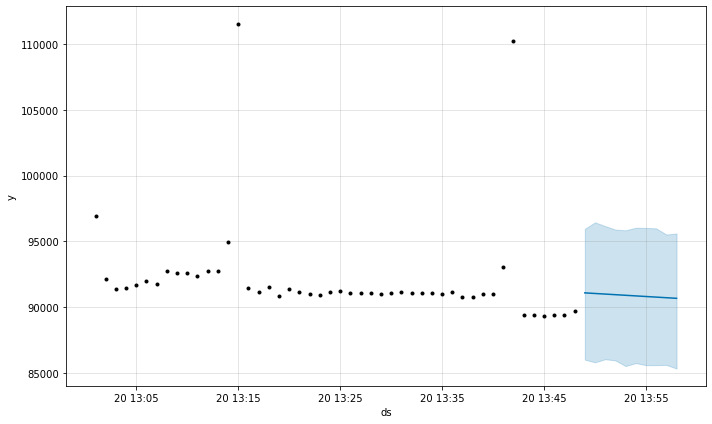

In [ ]:
fig1 = m.plot(forecast)

More than three second at every lap, this is some serious error. Let's try to drop the pitstops rows !

In [ ]:
df_W_pit = pd.merge(df_merged, pit_stops, on=['raceId',"lap", "driverId"], how="left")

df_W_pit[np.isfinite(df_W_pit["stop"])]

,raceId,year,name,round,lap,driverRef,driverId,position,time_x,milliseconds_x,date,time_y,circuitId,stop,time,duration,milliseconds_y
117876,841,2011,Australian Grand Prix,1,1,alguersuari,153,21,0 days 00:02:13.879000,133879,2011-03-27,06:00:00,1,1.0,17:05:23,26.898,26898.0
117877,841,2011,Australian Grand Prix,1,1,michael_schumacher,30,22,0 days 00:02:41.428000,161428,2011-03-27,06:00:00,1,1.0,17:05:52,25.021,25021.0
118081,841,2011,Australian Grand Prix,1,11,webber,17,7,0 days 00:01:54.995000,114995,2011-03-27,06:00:00,1,1.0,17:20:48,23.426,23426.0
118107,841,2011,Australian Grand Prix,1,12,alonso,4,12,0 days 00:01:52.624000,112624,2011-03-27,06:00:00,1,1.0,17:22:34,23.251,23251.0
118127,841,2011,Australian Grand Prix,1,13,massa,13,11,0 days 00:01:54.060000,114060,2011-03-27,06:00:00,1,1.0,17:24:10,23.842,23842.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386806,1096,2022,Abu Dhabi Grand Prix,22,39,russell,847,5,0 days 00:01:32.517000,92517,2022-11-20,13:00:00,24,2.0,18:02:44,27.931,27931.0
386829,1096,2022,Abu Dhabi Grand Prix,22,40,stroll,840,9,0 days 00:01:33.566000,93566,2022-11-20,13:00:00,24,2.0,18:04:44,21.802,21802.0
386847,1096,2022,Abu Dhabi Grand Prix,22,41,ocon,839,8,0 days 00:01:33.031000,93031,2022-11-20,13:00:00,24,2.0,18:06:09,21.734,21734.0
386864,1096,2022,Abu Dhabi Grand Prix,22,42,norris,846,6,0 days 00:01:33.097000,93097,2022-11-20,13:00:00,24,2.0,18:07:36,21.559,21559.0


In [ ]:
toDrop = []
for name, group in df_W_pit.groupby(["raceId", "driverId"]):
    toDrop.append(group.index[0])
    for i in range(len(group)):
        if np.isfinite(group["stop"].iloc[i]):
            toDrop.extend([group.index[i], group.index[i+1] if i+1 < len(group) else None])

toDrop = [item for item in toDrop if item is not None]
print(len(toDrop))
df_W_pit.drop(index=toDrop,inplace=True)
df_W_pit.drop(columns=["time","duration","milliseconds_y","stop"], inplace=True)

df_W_pit

26334


,raceId,year,name,round,lap,driverRef,driverId,position,time_x,milliseconds_x,date,time_y,circuitId
20,71,2005,Australian Grand Prix,1,2,fisichella,21,1,0 days 00:01:29.955000,89955,2005-03-06,14:00:00,1
21,71,2005,Australian Grand Prix,1,2,trulli,15,2,0 days 00:01:29.938000,89938,2005-03-06,14:00:00,1
22,71,2005,Australian Grand Prix,1,2,coulthard,14,3,0 days 00:01:30.490000,90490,2005-03-06,14:00:00,1
23,71,2005,Australian Grand Prix,1,2,webber,17,4,0 days 00:01:30.705000,90705,2005-03-06,14:00:00,1
24,71,2005,Australian Grand Prix,1,2,heidfeld,2,5,0 days 00:01:30.576000,90576,2005-03-06,14:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
387165,1096,2022,Abu Dhabi Grand Prix,22,58,ocon,839,7,0 days 00:01:30.021000,90021,2022-11-20,13:00:00,24
387166,1096,2022,Abu Dhabi Grand Prix,22,58,stroll,840,8,0 days 00:01:31.330000,91330,2022-11-20,13:00:00,24
387167,1096,2022,Abu Dhabi Grand Prix,22,58,ricciardo,817,9,0 days 00:01:30.856000,90856,2022-11-20,13:00:00,24
387168,1096,2022,Abu Dhabi Grand Prix,22,58,vettel,20,10,0 days 00:01:30.351000,90351,2022-11-20,13:00:00,24


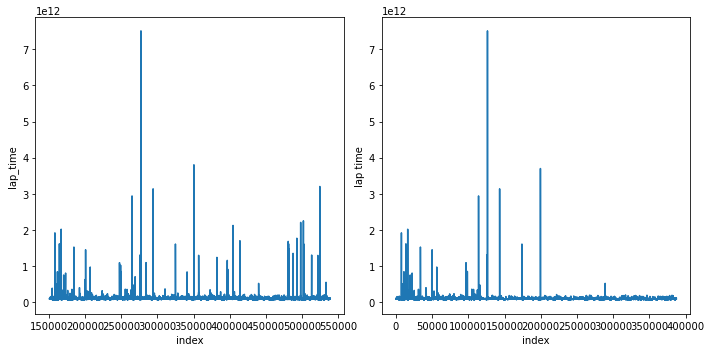

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[1].plot(df_W_pit.index, df_W_pit['time_x'])
axs[1].set_xlabel('index')
axs[1].set_ylabel('lap time')

axs[0].plot(df_merged.index, df_merged['time_x'])
axs[0].set_xlabel('index')
axs[0].set_ylabel('lap_time')

plt.tight_layout()
plt.show()

We can see that we don't have all the pit stops in our dataframe, but il should be enough

In [ ]:
nb_laps_to_predict = 4

df_OCO_ABU2022 = df_W_pit.loc[(df_W_pit["year"]==2022) & (df_W_pit["name"]=="Abu Dhabi Grand Prix") & (df_W_pit["driverRef"]=="ocon")]

df_OCO_ABU2022 = df_OCO_ABU2022[["date", "time_y","lap", "milliseconds_x"]]
#I volontarely add only one minute by lap
df_OCO_ABU2022["ds"] = df_OCO_ABU2022.apply(lambda row : np.datetime64(row.date+'T'+row.time_y)+np.timedelta64(row.lap,'m'), axis=1)
df_OCO_ABU2022 = df_OCO_ABU2022.rename(columns={"milliseconds_x":"y"}).reset_index(drop=True)[["ds",'y']]

ts_train = df_OCO_ABU2022[:-nb_laps_to_predict]
ts_test = df_OCO_ABU2022[-nb_laps_to_predict:]
ts_test_ds = ts_test[["ds"]]

m1 = Prophet()
m1.fit(ts_train)

forecast = m1.predict(ts_test_ds)
forecast["y"] = ts_test["y"].reset_index(drop=True)
forecast["diff (s)"] = (forecast["yhat"]-forecast["y"])/1000

print("mean of the diff :",np.mean(abs(forecast["diff (s)"])))
forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', "diff (s)"]]


SyntaxError: invalid syntax (<ipython-input-185-df68bb8db7b4>, line 21)

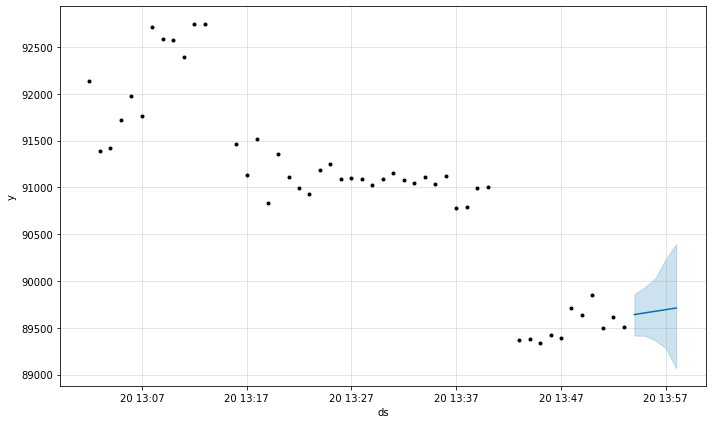

In [ ]:
fig2 = m1.plot(forecast)

We can see that we obtain better results, but we should try to train with another model : arima

In [ ]:
nb_laps_to_predict = 10

df_OCO_ABU2022 = df_W_pit.loc[(df_W_pit["year"]==2022) & (df_W_pit["name"]=="Abu Dhabi Grand Prix") & (df_W_pit["driverRef"]=="ocon")]

df_OCO_ABU2022 = df_OCO_ABU2022[["date", "time_y","lap", "milliseconds_x"]]
#I volontarely add only one minute by lap
df_OCO_ABU2022["ds"] = df_OCO_ABU2022.apply(lambda row : np.datetime64(row.date+'T'+row.time_y)+np.timedelta64(row.lap,'m'), axis=1)
df_OCO_ABU2022 = df_OCO_ABU2022.rename(columns={"milliseconds_x":"y"}).set_index("ds")[['y']]

ts_train = df_OCO_ABU2022[:-nb_laps_to_predict]
ts_test = df_OCO_ABU2022[-nb_laps_to_predict:]

model = sm.tsa.ARIMA(ts_train['y'], order=(1,1,1))
model_fit = model.fit()

preds = model_fit.forecast(steps=nb_laps_to_predict)

ts_test["y_pred"] = preds[0]
ts_test["diff (s)"] = (ts_test["y_pred"]-ts_test["y"])/1000

print("mean of the diff :",np.mean(abs(ts_test["diff (s)"])))
ts_test[['y', 'y_pred', "diff (s)"]]


mean of the diff : 0.17817211447822773


c:\Users\henri\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\Users\henri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

,y,y_pred,diff (s)
ds,,,
2022-11-20 13:49:00,89641,89706.343822,0.065344
2022-11-20 13:50:00,89848,89688.763942,-0.159236
2022-11-20 13:51:00,89502,89659.235962,0.157236
2022-11-20 13:52:00,89611,89621.272643,0.010273
2022-11-20 13:53:00,89506,89577.353993,0.071354
2022-11-20 13:54:00,89434,89529.230889,0.095231
2022-11-20 13:55:00,89491,89478.139448,-0.012861
2022-11-20 13:56:00,89725,89424.952368,-0.300048
2022-11-20 13:57:00,89574,89370.285770,-0.203714


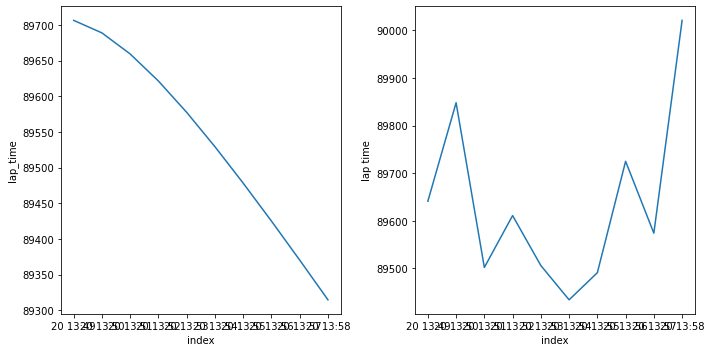

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[1].plot(ts_test.index, ts_test['y'])
axs[1].set_xlabel('index')
axs[1].set_ylabel('lap time')

axs[0].plot(ts_test.index, ts_test['y_pred'])
axs[0].set_xlabel('index')
axs[0].set_ylabel('lap_time')

plt.tight_layout()
plt.show()